In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from random import randrange

#load dataframes
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



Using TensorFlow backend.


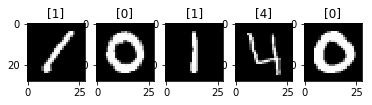

In [2]:
#seperates label from pixel values
train_x = train.iloc[:,1:]
train_y = train.iloc[:,:1]

#reshape data and display label/image from reshaped data
ax = plt.subplots(1,5)
for i in range(0,5):
    ax[1][i].imshow(train_x.values[i].reshape(28,28), cmap='gray')
    ax[1][i].set_title(train_y.values[i])

In [3]:
#building the CNN model function
def cnn_model(result_class_size):
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(28,28,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(result_class_size, activation='softmax'))   
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    return model

#creating the model
aTrain_y = np_utils.to_categorical(train_y['label'].values)
model = cnn_model(aTrain_y.shape[1])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
#normalization of greyscale vals to 0 or 1
test = test/ 255
train_x= train_x / 255

#training and testing data is reshaped
train_x_28x28 = np.reshape(train_x.values, (train_x.values.shape[0], 28, 28, 1))
test_x_28x28 = np.reshape(test.values, (test.values.shape[0], 28, 28, 1))

#spearate 8% of testing data into validation data
random_seed = 7
split_train_x, split_val_x, split_train_y, split_val_y, = train_test_split(train_x_28x28, aTrain_y, test_size = 0.08, random_state=random_seed)


In [5]:
#creates a way to adjust the learning rate while training model
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                              factor=0.3, 
                              patience=3, 
                              min_lr=0.0001)

In [6]:
#uses the image generator from Keras to produce more images to test against than the original dataset provides. 
datagen = ImageDataGenerator( rotation_range=10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1) 
datagen.fit(split_train_x)

#uses 30 rounds to train the model against testing and validation sets using the LR reduction technique in addition to the image generator
model.fit_generator(datagen.flow(split_train_x,split_train_y, batch_size=64),
                    epochs = 30, validation_data = (split_val_x,split_val_y),
                    verbose = 2, steps_per_epoch=640, callbacks=[reduce_lr])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 16s - loss: 0.4144 - acc: 0.8660 - val_loss: 0.0811 - val_acc: 0.9774
Epoch 2/30
 - 16s - loss: 0.1466 - acc: 0.9556 - val_loss: 0.0568 - val_acc: 0.9836
Epoch 3/30
 - 17s - loss: 0.1036 - acc: 0.9676 - val_loss: 0.0462 - val_acc: 0.9854
Epoch 4/30
 - 18s - loss: 0.0876 - acc: 0.9730 - val_loss: 0.0468 - val_acc: 0.9866
Epoch 5/30
 - 18s - loss: 0.0770 - acc: 0.9766 - val_loss: 0.0440 - val_acc: 0.9869
Epoch 6/30
 - 17s - loss: 0.0698 - acc: 0.9786 - val_loss: 0.0394 - val_acc: 0.9896
Epoch 7/30
 - 17s - loss: 0.0655 - acc: 0.9799 - val_loss: 0.0469 - val_acc: 0.9863
Epoch 8/30
 - 17s - loss: 0.0574 - acc: 0.9820 - val_loss: 0.0332 - val_acc: 0.9917
Epoch 9/30
 - 17s - loss: 0.0602 - acc: 0.9819 - val_loss: 0.0411 - val_acc: 0.9908
Epoch 10/30
 - 17s - loss: 0.0576 - acc: 0.9827 - val_loss: 0.0396 - val_acc: 0.9908
Epoch 11/30
 - 16s - loss: 0.0550 - acc: 0.9833 - val_loss: 0.0366 - val_acc: 0.9899
Epoch 12/30
 - 17s - loss:

In [7]:
#create prediction and export
prediction = model.predict_classes(test_x_28x28, verbose=0)
submission = pd.DataFrame({"ImageId": list(range(1,len(prediction)+1)), "Label": prediction})
submission.to_csv("result.csv", header=True, index = False)


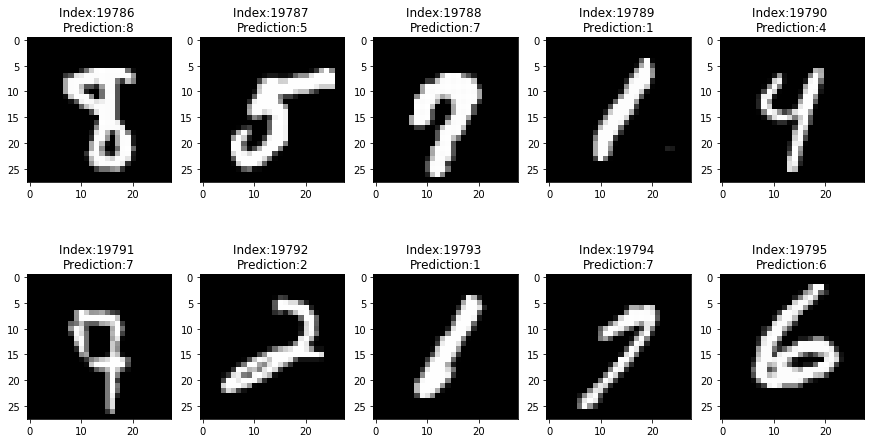

In [11]:
#see results of the model after training to ensure its accurate
start_idx = randrange(test.shape[0]-10)
fig, ax = plt.subplots(2,5, figsize=(15,8))
for j in range(0,2):
    for i in range(0,5):
        ax[j][i].imshow(test.values[start_idx].reshape(28,28), cmap='gray')
        ax[j][i].set_title("Index:{} \nPrediction:{}".format(start_idx, prediction[start_idx]))
        start_idx +=1